# Glass structure - evolutionary approach

In [1]:
import numpy as np

In [2]:
rng = np.random.default_rng()

## Data preparation

In [3]:
from itertools import dropwhile, takewhile
import re

def read_atoms(input_path):
    with open(input_path, 'r') as file:
        lines = file.readlines()
        
        atom_spec_lines = list(takewhile(lambda line: line != 'ATOMIC_POSITIONS (angstrom)\n', dropwhile(lambda line: line != 'ATOMIC_SPECIES\n', lines)))[1:]
        atom_species_by_index = {i: symbol for i, symbol in enumerate([line.split()[0] for line in atom_spec_lines])}
        atom_species_by_symbol = {symbol: i for i, symbol in atom_species_by_index.items()}
        
        atom_pos_lines = list(dropwhile(lambda line: line != 'ATOMIC_POSITIONS (angstrom)\n', lines))[1:-2]
        atom_positions = [(float(x), float(y), float(z), atom_species_by_symbol[symbol]) for symbol, x, y, z in [line.split() for line in atom_pos_lines]]

        cell_size_line = next(line for line in lines if line.startswith('  ibrav'))
        cell_size_match = re.search(r'a=(\d+(\.\d+)?)', cell_size_line)
        cell_size = float(cell_size_match.group(1)) if cell_size_match else None

    return atom_species_by_index, atom_species_by_symbol, np.array(atom_positions), cell_size

In [4]:
def get_solution_size(cluster_size, solution_thickness, axis):
    match axis:
        case 0:
            size_x = solution_thickness
            size_y = cluster_size
            size_z = cluster_size
        case 1:
            size_x = cluster_size + solution_thickness
            size_y = solution_thickness
            size_z = cluster_size
        case 2:
            size_x = cluster_size + solution_thickness
            size_y = cluster_size + solution_thickness
            size_z = solution_thickness

    return size_x, size_y, size_z

In [5]:
def cut_atoms(atoms, center, x_size, y_size, z_size):
    x_min, x_max = center[0] - x_size/2, center[0] + x_size/2
    y_min, y_max = center[1] - y_size/2, center[1] + y_size/2
    z_min, z_max = center[2] - z_size/2, center[2] + z_size/2

    center_coords = np.array(np.concat([center[:3], [0]]))

    return atoms[np.all([
        atoms[:, 0] > x_min, 
        atoms[:, 0] < x_max, 
        atoms[:, 1] > y_min, 
        atoms[:, 1] < y_max, 
        atoms[:, 2] > z_min, 
        atoms[:, 2] < z_max
    ], axis=0)] - center_coords

In [6]:
def get_positioned_walls_x(cluster, cluster_size, wall_thickness, solution_thickness):
    wall_x_left = cluster[cluster[:, 0] < -cluster_size / 2 + wall_thickness]
    wall_x_right = cluster[cluster[:, 0] > cluster_size / 2 - wall_thickness]

    wall_x_left_shifted = wall_x_left + np.array([cluster_size/2 + solution_thickness/2, 0, 0, 0])
    wall_x_right_shifted = wall_x_right - np.array([cluster_size/2 + solution_thickness/2, 0, 0, 0])

    return wall_x_left_shifted, wall_x_right_shifted


def get_positioned_walls_y(solution_x, cluster, cluster_size, wall_thickness, solution_thickness):
    atoms = np.concat([cluster, solution_x])

    wall_y_bottom = atoms[atoms[:, 1] < -cluster_size / 2 + wall_thickness]
    wall_y_top = atoms[atoms[:, 1] > cluster_size / 2 - wall_thickness]

    wall_y_bottom_shifted = wall_y_bottom + np.array([0, cluster_size/2 + solution_thickness/2, 0, 0])
    wall_y_top_shifted = wall_y_top - np.array([0, cluster_size/2 + solution_thickness/2, 0, 0])

    return wall_y_bottom_shifted, wall_y_top_shifted


def get_positioned_walls_z(solution_x, solution_y, cluster, cluster_size, wall_thickness, solution_thickness):
    atoms = np.concat([cluster, solution_x, solution_y])

    wall_z_back = atoms[atoms[:, 2] < -cluster_size / 2 + wall_thickness]
    wall_z_front = atoms[atoms[:, 2] > cluster_size / 2 - wall_thickness]

    wall_z_back_shifted = wall_z_back + np.array([0, 0, cluster_size/2 + solution_thickness/2, 0])
    wall_z_front_shifted = wall_z_front - np.array([0, 0, cluster_size/2 + solution_thickness/2, 0])

    return wall_z_back_shifted, wall_z_front_shifted

In [7]:
def get_random_solution(supercell, cell_size, x_size, y_size, z_size):
    center = rng.uniform(-cell_size/2, cell_size/2, 3)
    return cut_atoms(supercell, center, x_size, y_size, z_size)


def get_random_solution_without_Er(supercell, cell_size, atom_species_by_symbol, x_size, y_size, z_size):
    solution = get_random_solution(supercell, cell_size, x_size, y_size, z_size)
    while np.any(solution[:, 3] == atom_species_by_symbol['Er']):
        solution = get_random_solution(supercell, cell_size, x_size, y_size, z_size)

    solution[solution[:, 3] != atom_species_by_symbol['O'], 3] = atom_species_by_symbol['Si']

    return solution


def get_n_random_solutions_without_Er(supercell, cell_size, atom_species_by_symbol, cluster_size, solution_thickness, axis, n):
    x_size, y_size, z_size = get_solution_size(cluster_size, solution_thickness, axis)

    return [get_random_solution_without_Er(supercell, cell_size, atom_species_by_symbol, x_size, y_size, z_size) for _ in range(n)]

In [8]:
from itertools import product

def get_supercell(cell, cell_size):
    shift_options = [-cell_size, 0, cell_size]
    return np.concat([cell + np.array(shift_vector + (0,)) for shift_vector in product(shift_options, repeat=3)])

In [9]:
def get_Er_clusters(supercell, cluster_size, atom_species_by_symbol):
    atoms_Er = supercell[supercell[:, 3] == atom_species_by_symbol['Er']]
    return [cut_atoms(supercell, center, cluster_size, cluster_size, cluster_size) for center in atoms_Er]

In [10]:
# import os

# example_path = 'data/examples/ex1'
# rel_path = lambda filename: os.path.join(example_path, filename)

# # cluster_size = 12.0
# wall_thickness = 3.0
# solution_thickness = 3.0

# atom_species_by_index, atom_species_by_symbol, er_cluster, cluster_size = read_atoms(rel_path('F21.in'))
# wall_x_left, wall_x_right = get_positioned_walls_x(er_cluster, cluster_size, wall_thickness, solution_thickness)

In [11]:
import matplotlib.pyplot as plt


def plot_atoms_on_ax(atoms, atom_species_by_index, marker, ax):
    for atom_index in np.unique(atoms[:, 3]):
        atom_positions = atoms[atoms[:, 3] == atom_index]
        ax.scatter(
            atom_positions[:, 0], 
            atom_positions[:, 1], 
            atom_positions[:, 2], 
            label=atom_species_by_index[atom_index], 
            marker=marker, 
            c=plt.cm.jet(atom_index / len(atom_species_by_index)))


def plot_atoms(atoms, atom_species_by_index,):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    plot_atoms_on_ax(atoms, atom_species_by_index, 'o', ax)
    
    ax.legend()
    plt.show()


def plot_solution_with_walls(walls, solution, atom_species_by_index):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    plot_atoms_on_ax(np.concat(walls), atom_species_by_index, '^', ax)
    plot_atoms_on_ax(solution, atom_species_by_index, 'o', ax)

    ax.legend()
    plt.show()

In [12]:
def split_and_shift_solution(solution, cluster_size, axis):
    if solution is None:
        return np.array([])

    shift_vector = np.array([0, 0, 0, 0])
    shift_vector[axis] = cluster_size / 2

    minor_half = solution[solution[:, axis] < 0]
    major_half = solution[solution[:, axis] >= 0]
    
    minor_half_shifted = minor_half - shift_vector
    major_half_shifted = major_half + shift_vector

    return np.concat([minor_half_shifted, major_half_shifted])


def export_to_xcrysden(cluster, x_solution, y_solution, z_solution, cluster_size, solution_thickness, atom_species_by_index, filename):
    x_solution_shifted = split_and_shift_solution(x_solution, cluster_size, 0)
    y_solution_shifted = split_and_shift_solution(y_solution, cluster_size, 1)
    z_solution_shifted = split_and_shift_solution(z_solution, cluster_size, 2)

    all_atoms = np.concat([cluster, x_solution_shifted, y_solution_shifted, z_solution_shifted])
    n_atoms = len(all_atoms)
    cell_size = cluster_size + solution_thickness
    
    preamble = f'''cell 
&CONTROL
  calculation='scf'
  restart_mode='from_scratch'
  pseudo_dir = './pseudo/',
  outdir='./tmp/'
  prefix='cell',
  wf_collect=.true.
 /
 &system
  ibrav= 1, nat={n_atoms}, a={cell_size}, ntyp={len(atom_species_by_index)},
 /
 &electrons
  conv_thr = 0.04  
  diagonalization='davidson'
  mixing_beta = 0.1
 /'''
    
    atom_species_formatted = '\n'.join(f'{symbol}   1.0   {symbol}.pz-n-nc.UPF' for symbol in atom_species_by_index.values())

    atom_species_part = f'''
ATOMIC_SPECIES
{atom_species_formatted}'''

    atom_positions_formatted = '\n'.join(f'{atom_species_by_index[species_index]}\t{x:.6f}\t{y:.6f}\t{z:.6f}' for x, y, z, species_index in all_atoms)

    atom_positions_part = f'''
ATOMIC_POSITIONS (angstrom)
{atom_positions_formatted}'''

    k_points_part = '''
K_POINTS {automatic}
2 2 2 0 0 0
'''

    with open(filename, 'w') as file:
        file.write(preamble)
        file.write(atom_species_part)
        file.write(atom_positions_part)
        file.write(k_points_part)

## Common algorithm components

### Fitness function

#### Density

In [13]:
def cubature(size_x, sizy_y, size_z):
    return size_x * sizy_y * size_z
    

def density_anions(atoms, size_x, sizy_y, size_z, atom_species_by_symbol):
    anions = atoms[atoms[:, 3] == atom_species_by_symbol['O']]
    return len(anions) / cubature(size_x, sizy_y, size_z)


def density_cations(atoms, size_x, sizy_y, size_z, atom_species_by_symbol):
    cations = atoms[atoms[:, 3] != atom_species_by_symbol['O']]
    return len(cations) / cubature(size_x, sizy_y, size_z)
    

In [14]:
# Expected density measurement

# anion_densities = []
# cation_densities = []

# for cell_name in ['448', '896', '1808', '3616']:
#     _atom_species_by_index, atom_species_by_symbol, cell, cell_size = read_atoms(f'./data/big cells/{cell_name}.in')

#     d_anions = density_anions(cell, cell_size, cell_size, cell_size, atom_species_by_symbol)
#     d_cations = density_cations(cell, cell_size, cell_size, cell_size, atom_species_by_symbol)

#     anion_densities.append(d_anions)
#     cation_densities.append(d_cations)

#     print(f'{cell_name}: {d_anions:.5} anions per Å^3')
#     print(f'{cell_name}: {d_cations:.5} cations per Å^3')

# avg_d_anions = np.mean(anion_densities)
# avg_d_cations = np.mean(cation_densities)

# print()
# print(f'Average anion density: {avg_d_anions:.5} anions per Å^3')
# print(f'Average cation density: {avg_d_cations:.5} cations per Å^3')


In [15]:
def penalty_density(atoms, size_x, size_y, size_z, atom_species_by_symbol):
    target_anion_density = 0.0395
    target_cation_density = 0.0237

    anions = atoms[atoms[:, 3] == atom_species_by_symbol['O']]
    cations = atoms[atoms[:, 3] != atom_species_by_symbol['O']]

    curr_anion_density = density_anions(anions, size_x, size_y, size_z, atom_species_by_symbol)
    curr_cation_density = density_cations(cations, size_x, size_y, size_z, atom_species_by_symbol)

    return ((target_anion_density - curr_anion_density) / target_anion_density) ** 2 + ((target_cation_density - curr_cation_density) / target_cation_density) ** 2

#### Distances

In [16]:
def distance_penalty_for_atom_species(atoms, first_species_index, second_species_index, threshold):
        first_atoms = atoms[atoms[:, 3] == first_species_index][:, :3]
        second_atoms = atoms[atoms[:, 3] == second_species_index][:, :3]

        distances = np.linalg.norm(first_atoms[:, None] - second_atoms, axis=-1)
        violations = distances < threshold if first_species_index != second_species_index else np.triu(distances < threshold, k=1)

        penalties = np.ones(distances.shape)[violations]
        return np.sum(penalties)


def penalty_distances(atoms, atom_species_by_symbol):
    checked_distances = [
        ('O', 'O', 2.6),
        ('O', 'Si', 1.6),
        ('Si', 'Si', 2.9)
    ]

    return sum([distance_penalty_for_atom_species(atoms, atom_species_by_symbol[first_species], atom_species_by_symbol[second_species], threshold) for first_species, second_species, threshold in checked_distances])

#### Angles

In [17]:
def angle_penalty_for_atom_species(atoms, anion_index, cation_index, distance_threshold):
    angle_hard_lower_threshold_deg = 70
    angle_soft_lower_threshold_deg = 100
    angle_soft_upper_threshold_deg = 130
    angle_hard_upper_threshold_deg = 180

    anions = atoms[atoms[:, 3] == anion_index][:, :3]
    cations = atoms[atoms[:, 3] == cation_index][:, :3]
    
    cation_anion_distances = np.linalg.norm(cations[:, None] - anions, axis=-1)
    cation_nearest_neighbour_indices = np.argpartition(cation_anion_distances, 2, axis=1)[:, :2]
    cation_between_nearest_neighbours = np.concat([anions[cation_nearest_neighbour_indices[:, 0, None]], cations[:, None], anions[cation_nearest_neighbour_indices[:, 1, None]]], axis=1)

    vectors = np.diff(cation_between_nearest_neighbours, axis=1)
    vectors[:, 0] *= -1
    vector_lengths = np.linalg.norm(vectors, axis=-1)

    short_vector_indices = np.logical_and(vector_lengths[:, 0] < distance_threshold, vector_lengths[:, 1] < distance_threshold)
    short_vectors = vectors[short_vector_indices]
    short_vector_lengths = vector_lengths[short_vector_indices]

    angles = np.arccos(np.sum(short_vectors[:, 0] * short_vectors[:, 1], axis=-1) / (short_vector_lengths[:, 0] * short_vector_lengths[:, 1]))
    angles_deg = np.degrees(angles)

    hard_violations = np.logical_or(angles_deg < angle_hard_lower_threshold_deg, angles_deg > angle_hard_upper_threshold_deg)
    soft_violations_lower = np.logical_and(angles_deg <= angle_soft_lower_threshold_deg, angles_deg > angle_hard_lower_threshold_deg)
    soft_violations_upper = np.logical_and(angles_deg < angle_hard_upper_threshold_deg, angles_deg >= angle_soft_upper_threshold_deg)

    hard_violations_penalty = np.sum(np.ones(angles_deg.shape)[hard_violations])
    soft_violations_lower_penalty = np.sum((angle_soft_lower_threshold_deg - angles_deg[soft_violations_lower]) / (angle_soft_lower_threshold_deg - angle_hard_lower_threshold_deg))
    soft_violations_upper_penalty = np.sum((angles_deg[soft_violations_upper] - angle_soft_upper_threshold_deg) / (angle_hard_upper_threshold_deg - angle_soft_upper_threshold_deg))

    return hard_violations_penalty + soft_violations_lower_penalty + soft_violations_upper_penalty


def penalty_angles(atoms, atom_species_by_symbol):
    checked_angles = [
        ('O', 'Si', 2.6)
    ]

    return sum([angle_penalty_for_atom_species(atoms, atom_species_by_symbol[anion], atom_species_by_symbol[cation], threshold) for anion, cation, threshold in checked_angles])

#### Fitness

In [18]:
def fitness_func(atoms, atom_species_by_symbol, size_x, size_y, size_z, alpha, beta, gamma):
    return -1 * (
        alpha * penalty_density(atoms, size_x, size_y, size_z, atom_species_by_symbol) 
        + beta * penalty_distances(atoms, atom_species_by_symbol) 
        + gamma * penalty_angles(atoms, atom_species_by_symbol)
    )

In [19]:
def fitness_x(wall_left, wall_right, solution, atom_species_by_symbol, cluster_size, wall_thickness, solution_thickness, alpha=1.0, beta=1.0, gamma=1.0):
    atoms = np.concat([wall_left, wall_right, solution])

    size_x = 2 * wall_thickness + solution_thickness
    size_y = cluster_size
    size_z = cluster_size

    return fitness_func(atoms, atom_species_by_symbol, size_x, size_y, size_z, alpha, beta, gamma)


def fitness_y(wall_down, wall_up, solution, atom_species_by_symbol, cluster_size, wall_thickness, solution_thickness, alpha=1.0, beta=1.0, gamma=1.0):
    periodic_x_left_wall = solution[solution[:, 0] < -cluster_size/2] + np.array([cluster_size + 2 * wall_thickness, 0, 0, 0])
    periodic_x_right_wall = solution[solution[:, 0] > cluster_size/2] - np.array([cluster_size + 2 * wall_thickness, 0, 0, 0])

    atoms = np.concat([wall_down, wall_up, solution, periodic_x_left_wall, periodic_x_right_wall])

    size_x = cluster_size + solution_thickness
    size_y = 2 * wall_thickness + solution_thickness
    size_z = cluster_size
    
    return fitness_func(atoms, atom_species_by_symbol, size_x, size_y, size_z, alpha, beta, gamma)


def fitness_z(wall_front, wall_back, solution, atom_species_by_symbol, cluster_size, wall_thickness, solution_thickness, alpha=1.0, beta=1.0, gamma=1.0):
    periodic_x_left_wall = solution[solution[:, 0] < -cluster_size/2] + np.array([cluster_size + 2 * wall_thickness, 0, 0, 0])
    periodic_x_right_wall = solution[solution[:, 0] > cluster_size/2] - np.array([cluster_size + 2 * wall_thickness, 0, 0, 0])
    periodic_y_down_wall = solution[solution[:, 1] < -cluster_size/2] + np.array([0, cluster_size + 2 * wall_thickness, 0, 0])
    periodic_y_up_wall = solution[solution[:, 1] > cluster_size/2] - np.array([0, cluster_size + 2 * wall_thickness, 0, 0])

    atoms = np.concat([wall_front, wall_back, solution, periodic_x_left_wall, periodic_x_right_wall, periodic_y_down_wall, periodic_y_up_wall])

    size_x = cluster_size + solution_thickness
    size_y = cluster_size + solution_thickness
    size_z = 2 * wall_thickness + solution_thickness

    return fitness_func(atoms, atom_species_by_symbol, size_x, size_y, size_z, alpha, beta, gamma)

## Evolutionary algorithms

### Classic genetic algorithm

#### Genotype and fenotype

**Fenotype** - vector of atoms, i.e. np.array([[x,y,z,Sp],...])

**Genotype** - vector which elements correspond to space chunks, each element is a vector of atoms in that chunk of space, i.e. [[[x,y,z,Sp],...],...]

In [20]:
def genotype_to_fenotype(genotype):
    return np.concat(genotype)


def fenotype_to_genotype(fenotype, cluster_size, solution_thickness, axis, n_chunks=10):    # space_size = (x_size, y_size, z_size)
    chunk_axis = (axis + 1) % 3   # Y for x-solution, Z for y-solution, X for z-solution
    space_size = get_solution_size(cluster_size, solution_thickness, axis)

    lower_bound = -space_size[chunk_axis] / 2
    chunk_size = space_size[chunk_axis] / n_chunks

    return [
        fenotype[np.all([
            fenotype[:, chunk_axis] >= lower_bound + i * chunk_size, 
            fenotype[:, chunk_axis] < lower_bound + (i + 1) * chunk_size
        ], axis=0)] for i in range(n_chunks)
    ]

#### Crossover

In [21]:
# def crossover_n_parts(genotypes):
#     n_samples = len(genotypes)
#     genotype_length = len(genotypes[0])
#     single_genotype_chunk_length = genotype_length // n_samples

#     shuffled_genotypes = rng.permutation(genotypes)
#     new_genotype_parts = [genotype[single_genotype_chunk_length * i : single_genotype_chunk_length * (i + 1)] for i, genotype in enumerate(shuffled_genotypes[:-1])] + [shuffled_genotypes[-1][single_genotype_chunk_length * (n_samples - 1):]]

#     return [gene for genotype_part in new_genotype_parts for gene in genotype_part]

In [22]:
def crossover_fenotypes(parent_fenotypes, cluster_size, solution_thickness, axis):
    n_parents = len(parent_fenotypes)

    chunk_axis = (axis + 1) % 3   # Y for x-solution, Z for y-solution, X for z-solution
    solution_size_in_chunk_axis = get_solution_size(cluster_size, solution_thickness, axis)[chunk_axis]
    chunk_size = solution_size_in_chunk_axis / n_parents
    min_coord_in_chunk_axis = -solution_size_in_chunk_axis / 2
    
    return np.concat([
        fenotype[np.all([
            fenotype[:, chunk_axis] >= min_coord_in_chunk_axis + i * chunk_size, 
            fenotype[:, chunk_axis] < min_coord_in_chunk_axis + (i+1) * chunk_size
            ], axis=0)]
        for i, fenotype in enumerate(parent_fenotypes)])

#### Mutations

In [23]:
# TODO: reimplement for genoptypes..?

def mut_add_anion(solution_fenotype, size_x, size_y, size_z, atom_species_by_symbol):
    random_anion = np.array([rng.uniform(-size_x/2, size_x/2), rng.uniform(-size_y/2, size_y/2), rng.uniform(-size_z/2, size_z/2), atom_species_by_symbol['O']])
    return np.concat([solution_fenotype, random_anion[None, :]])


def mut_remove_anion(solution_fenotype, _size_x, _size_y, _size_z, atom_species_by_symbol):
    anions_indices = np.argwhere(solution_fenotype[:, 3] == atom_species_by_symbol['O'])
    if len(anions_indices) == 0:
        return solution_fenotype

    index_of_anion_to_remove = rng.choice(anions_indices)[0]
    return np.concat([solution_fenotype[:index_of_anion_to_remove], solution_fenotype[index_of_anion_to_remove + 1:]])


def mut_add_cation(solution_fenotype, size_x, size_y, size_z, atom_species_by_symbol):
    random_cation_species = atom_species_by_symbol['Si']
    random_cation = np.array([rng.uniform(-size_x/2, size_x/2), rng.uniform(-size_y/2, size_y/2), rng.uniform(-size_z/2, size_z/2), random_cation_species])
    return np.concat([solution_fenotype, random_cation[None, :]])


def mut_remove_cation(solution_fenotype, _size_x, _size_y, _size_z, atom_species_by_symbol):
    cation_indeices = np.argwhere(solution_fenotype[:, 3] != atom_species_by_symbol['O'])
    if len(cation_indeices) == 0:
        return solution_fenotype
    
    index_of_cation_to_remove = rng.choice(cation_indeices)[0]
    return np.concat([solution_fenotype[:index_of_cation_to_remove], solution_fenotype[index_of_cation_to_remove + 1:]])

def mut_shift_atom(solution_fenotype, size_x, size_y, size_z, atom_species_by_symbol):
    index_of_atom_to_move = rng.integers(0, len(solution_fenotype))
    
    while True:
        shift_length = rng.gamma(2, 2, 3) / 10.     # mean = 0.2, std = 0.14
        direction_vector = rng.normal(size=3)
        
        scaled_direction_vector = direction_vector / np.linalg.norm(direction_vector) * shift_length
        shift_vector = np.concat([scaled_direction_vector, [0]])

        moved_atom = solution_fenotype[index_of_atom_to_move] + shift_vector

        if moved_atom[0] >= -size_x/2 and moved_atom[0] < size_x/2 and moved_atom[1] >= -size_y/2 and moved_atom[1] < size_y/2 and moved_atom[2] >= -size_z/2 and moved_atom[2] < size_z/2:
            return np.concat([solution_fenotype[:index_of_atom_to_move], moved_atom[None, :], solution_fenotype[index_of_atom_to_move + 1:]])

In [24]:
def random_mutation(mut_probabilities, solution_fenotype, cluster_size, solution_thickness, atom_species_by_symbol, axis):
    noop = lambda solution_fenotype, size_x, size_y, size_z, atom_species_by_symbol: solution_fenotype
    
    mutation = rng.choice(list(mut_probabilities.keys()) + [noop], p=list(mut_probabilities.values()) + [1 - sum(mut_probabilities.values())])

    size_x, size_y, size_z = get_solution_size(cluster_size, solution_thickness, axis)

    # solution_fenotype = genotype_to_fenotype(solution_genotype)
    mutated_solution_fenotype = mutation(solution_fenotype, size_x, size_y, size_z, atom_species_by_symbol)

    # n_genes = len(solution_genotype)
    # return fenotype_to_genotype(mutated_solution_fenotype, cluster_size, solution_thickness, axis, n_genes)

    return mutated_solution_fenotype

In [25]:
# import numpy as np

# shape, scale = 2, 2  # mean=4, std=2*sqrt(2)
# rng = np.random.default_rng()
# s = rng.gamma(shape, scale, 1000)

# import matplotlib.pyplot as plt
# import scipy.special as sps  
# count, bins, _ = plt.hist(s, 50, density=True)
# y = bins**(shape-1)*(np.exp(-bins/scale) /  
#                      (sps.gamma(shape)*scale**shape))
# plt.plot(bins, y, linewidth=2, color='r')  
# plt.show()

#### Selection

In [26]:
from itertools import combinations, permutations


def self_cartesian_product(array, n):
    shape = (len(array),) * n
    ix = np.indices(shape)
    return array[ix.reshape(n, -1).T]


def get_possible_matings_indices(population, n_parents_per_child):
    return [p for c in combinations(range(len(population)), n_parents_per_child) for p in permutations(c)]


def selection_proportional(population, fitness_func, n_parents_per_child, n_children):
    fitness_values = np.array([fitness_func(solution) for solution in population])
    min_fitness_value = np.min(fitness_values)
    fitness_values_shifted = fitness_values - min_fitness_value     # accomodate for negative fitness values
    total_fitness = np.sum(fitness_values_shifted)
    single_parent_probabilities = fitness_values_shifted / total_fitness

    possible_matings_indices = np.array(get_possible_matings_indices(population, n_parents_per_child))
    matings_prob_prod = np.prod(single_parent_probabilities[possible_matings_indices], axis=-1)
    mating_prob = matings_prob_prod / np.sum(matings_prob_prod)

    chosen_matings_indices = rng.choice(possible_matings_indices, size=n_children, p=mating_prob, replace=False)
    return [[population[index] for index in mating_indices] for mating_indices in chosen_matings_indices]

#### Genetic algorithm

In [27]:
class GeneticAlgorithm:
    def __init__(self, initial_population, mutation, crossover, selection, fitness):
        self.population = initial_population
        self.mutation = mutation    # mutation(solution_fenotype)
        self.crossover = crossover  # crossover(parents_fenotypes)
        self.selection = selection  # selection(population, fitness_func, n_parents_per_child, n_children)
        self.fitness = fitness

        self.avg_fitness_values = [np.mean([self.fitness(solution) for solution in self.population])]
        self.max_fitness_values = [np.max([self.fitness(solution) for solution in self.population])]
        self.best_solutions = [self.population[np.argmax([self.fitness(solution) for solution in self.population])]]


    def evolve(self, n_parents_per_child, n_children, n_elites, max_n_generations, tolerate_stagnation_for_n_generations, stagnation_epsilon, target_fitness_value=None):
        generation_idx = 0
        
        while not self._stop_condition(generation_idx, max_n_generations, tolerate_stagnation_for_n_generations, stagnation_epsilon, target_fitness_value):

            if generation_idx * 10 % max_n_generations == 0:
                print('Generation', generation_idx, 'avg fitness:', self.avg_fitness_values[-1], 'best fitness:', np.max(self.max_fitness_values))

            matings = self.selection(self.population, self.fitness, n_parents_per_child, n_children)
            children = [self.crossover(parents) for parents in matings]
            mutated_children = [self.mutation(child) for child in children]
            elites = [e[0] for e in self.selection(self.population, self.fitness, 1, n_elites)]

            self.population = elites + mutated_children

            self.avg_fitness_values.append(np.mean([self.fitness(solution) for solution in self.population]))
            self.max_fitness_values.append(np.max([self.fitness(solution) for solution in self.population]))
            self.best_solutions.append(self.population[np.argmax([self.fitness(solution) for solution in self.population])])

            generation_idx += 1

        print('Evolution ran for ', generation_idx, 'generations, reached best fitness of ', np.max(self.max_fitness_values))
        return self.population
    

    def get_best_solution(self):
        return self.best_solutions[np.argmax([self.fitness(solution) for solution in self.best_solutions])]
    

    def _stop_condition(self, generation_idx, max_n_generations, tolerate_stagnation_for_n_generations, stagnation_epsilon, target_fitness_value):
        if generation_idx >= max_n_generations:
            print('Reached maximum number of generations')
            return True

        if target_fitness_value is not None and np.max(self.max_fitness_values) > target_fitness_value:
            print('Reached target fitness value')
            return True

        if generation_idx >= tolerate_stagnation_for_n_generations:
            if np.all(self.avg_fitness_values[-tolerate_stagnation_for_n_generations:] - self.avg_fitness_values[-tolerate_stagnation_for_n_generations] < stagnation_epsilon):
                print('Reached stagnation')
                return True

        return False
    

    def plot_fitness(self):
        fig, ax = plt.subplots()
        ax.plot(self.avg_fitness_values, label='Average fitness')
        ax.plot(self.max_fitness_values, label='Max fitness')
        ax.legend()
        plt.show()


## Experiments

In [28]:
max_num_generations = 50
tolerate_stagnation_for_n_generations = 10
stagnation_epsilon = 0.2
target_fitness_value = 0.0

n_genes = 10

population_size = 70
n_parents_per_child = 2
n_children = 50
n_elites = population_size - n_children

mutation_probabilities = {
    mut_add_anion: 0.2,
    mut_remove_anion: 0.2,
    mut_add_cation: 0.1,
    mut_remove_cation: 0.1,
    mut_shift_atom: 0.4
}

In [29]:
cluster_size = 12.0
wall_thickness = 3.0
solution_thickness = 3.0

In [30]:
atom_species_by_index, atom_species_by_symbol, cell, cell_size = read_atoms('data/big cells/448.in')

supercell = get_supercell(cell, cell_size)
er_clusters = get_Er_clusters(supercell, cluster_size, atom_species_by_symbol)
er_cluster = er_clusters[0]

#### X-axis

In [31]:
wall_left, wall_right = get_positioned_walls_x(er_cluster, cluster_size, wall_thickness, solution_thickness)

In [32]:
initial_population = get_n_random_solutions_without_Er(supercell, 
                                                        cell_size, 
                                                        atom_species_by_symbol, 
                                                        cluster_size, 
                                                        solution_thickness, 
                                                        axis=0, 
                                                        n=population_size)

#initial_population = [fenotype_to_genotype(solution, cluster_size, solution_thickness, axis=0, n_chunks=n_genes) for solution in initial_population_fenotypes]

In [33]:
mutation_type = lambda offspring: random_mutation(mutation_probabilities, offspring, cluster_size, solution_thickness, atom_species_by_symbol, axis=0)

In [34]:
crossover = lambda parents: crossover_fenotypes(parents, cluster_size, solution_thickness, axis=0)

In [35]:
fitness_function = lambda solution: fitness_x(wall_left, wall_right, solution, atom_species_by_symbol, cluster_size, wall_thickness, solution_thickness)

In [36]:
ga_x = GeneticAlgorithm(initial_population, mutation_type, crossover, selection_proportional, fitness_function)

In [37]:
new_population = ga_x.evolve(n_parents_per_child, n_children, n_elites, max_num_generations, tolerate_stagnation_for_n_generations, stagnation_epsilon, target_fitness_value)

Generation 0 avg fitness: -13.651952876112611 best fitness: -5.761285753739597
Generation 5 avg fitness: -10.146660941481214 best fitness: -4.391396785239784
Generation 10 avg fitness: -9.044086900843352 best fitness: -3.421598747785258
Generation 15 avg fitness: -7.064848584330229 best fitness: -1.342215747542793
Generation 20 avg fitness: -5.486455957241607 best fitness: -1.342215747542793
Generation 25 avg fitness: -3.785869097290568 best fitness: -1.3054198970777966
Generation 30 avg fitness: -3.5941855444142887 best fitness: -1.3054198970777966
Generation 35 avg fitness: -2.687894097532487 best fitness: -1.3054198970777966
Generation 40 avg fitness: -1.9708399771613663 best fitness: -1.3054198970777966
Generation 45 avg fitness: -2.381045367608907 best fitness: -1.3054198970777966
Reached stagnation
Evolution ran for  48 generations, reached best fitness of  -1.3054198970777966


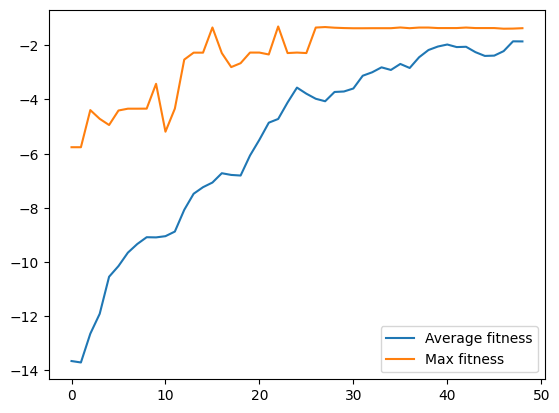

C:\Users\adams\AppData\Local\Temp\ipykernel_4296\3288827407.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(


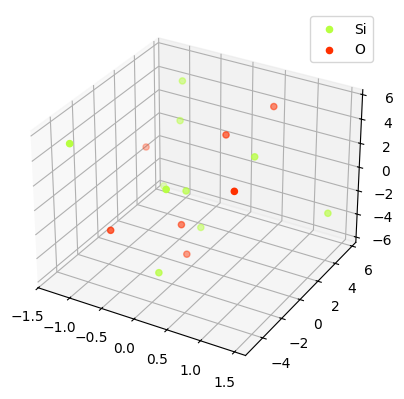

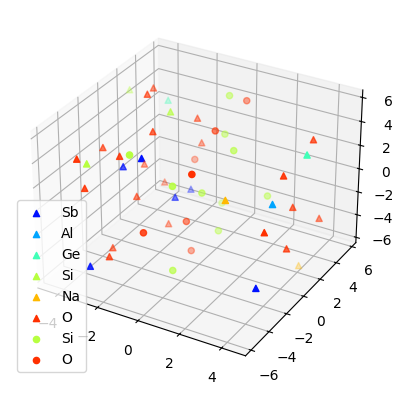

In [38]:
ga_x.plot_fitness()

best_solution_x = ga_x.get_best_solution()

plot_atoms(best_solution_x, atom_species_by_index)
plot_solution_with_walls((wall_left, wall_right), best_solution_x, atom_species_by_index)

####  Y-axis

In [39]:
wall_down, wall_up = get_positioned_walls_y(best_solution_x, er_cluster, cluster_size, wall_thickness, solution_thickness)

In [40]:
initial_population = get_n_random_solutions_without_Er(supercell, 
                                                        cell_size, 
                                                        atom_species_by_symbol, 
                                                        cluster_size, 
                                                        solution_thickness, 
                                                        axis=1, 
                                                        n=population_size)

In [41]:
mutation_type = lambda offspring: random_mutation(mutation_probabilities, offspring, cluster_size, solution_thickness, atom_species_by_symbol, axis=1)

In [42]:
crossover = lambda parents: crossover_fenotypes(parents, cluster_size, solution_thickness, axis=1)

In [43]:
fitness_function = lambda solution: fitness_y(wall_down, wall_up, solution, atom_species_by_symbol, cluster_size, wall_thickness, solution_thickness)

In [44]:
ga_y = GeneticAlgorithm(initial_population, mutation_type, crossover, selection_proportional, fitness_function)

In [45]:
new_population = ga_y.evolve(n_parents_per_child, n_children, n_elites, max_num_generations, tolerate_stagnation_for_n_generations, stagnation_epsilon, target_fitness_value)

Generation 0 avg fitness: -34.63592661627627 best fitness: -22.576447591020653
Generation 5 avg fitness: -29.593493903356705 best fitness: -21.565789349431945
Generation 10 avg fitness: -24.88575933039656 best fitness: -18.845167447732674
Generation 15 avg fitness: -22.303829289590066 best fitness: -15.861764430759669
Generation 20 avg fitness: -20.88064052387083 best fitness: -15.124750961477224
Generation 25 avg fitness: -17.582724104186205 best fitness: -12.661674905396076
Generation 30 avg fitness: -16.270891762270992 best fitness: -10.779815614811241
Generation 35 avg fitness: -15.200816382263975 best fitness: -10.779815614811241
Generation 40 avg fitness: -13.98358276106224 best fitness: -10.756907523432243
Generation 45 avg fitness: -13.292075265585476 best fitness: -10.754277918128869
Reached maximum number of generations
Evolution ran for  50 generations, reached best fitness of  -10.725032668591272


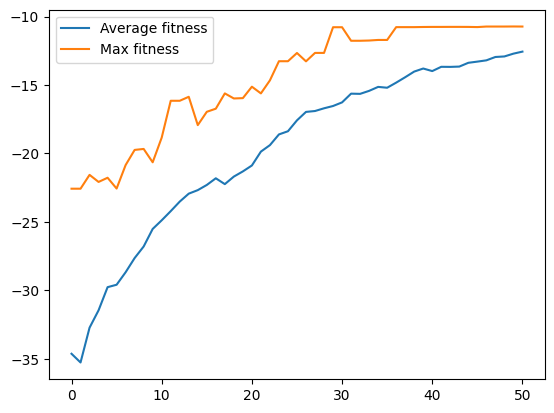

C:\Users\adams\AppData\Local\Temp\ipykernel_4296\3288827407.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(


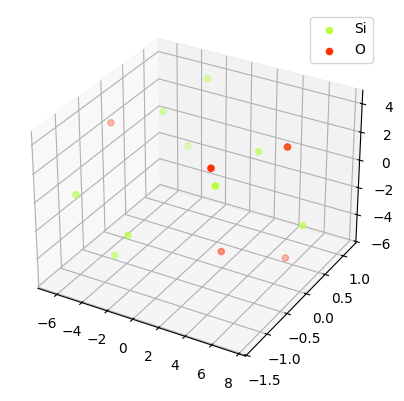

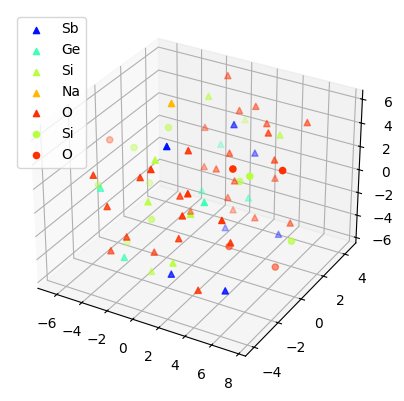

In [46]:
ga_y.plot_fitness()
best_solution_y = ga_y.get_best_solution()

plot_atoms(best_solution_y, atom_species_by_index)
plot_solution_with_walls((wall_down, wall_up), best_solution_y, atom_species_by_index)

####  Z-axis

In [47]:
wall_front, wall_back = get_positioned_walls_z(best_solution_x, best_solution_y, er_cluster, cluster_size, wall_thickness, solution_thickness)

In [48]:
initial_population = get_n_random_solutions_without_Er(supercell, 
                                                        cell_size, 
                                                        atom_species_by_symbol, 
                                                        cluster_size, 
                                                        solution_thickness, 
                                                        axis=2, 
                                                        n=population_size)

In [49]:
mutation_type = lambda offspring: random_mutation(mutation_probabilities, offspring, cluster_size, solution_thickness, atom_species_by_symbol, axis=2)

In [50]:
crossover = lambda parents: crossover_fenotypes(parents, cluster_size, solution_thickness, axis=2)

In [51]:
fitness_function = lambda solution: fitness_z(wall_front, wall_back, solution, atom_species_by_symbol, cluster_size, wall_thickness, solution_thickness)

In [52]:
ga_z = GeneticAlgorithm(initial_population, mutation_type, crossover, selection_proportional, fitness_function)

In [53]:
new_population = ga_z.evolve(n_parents_per_child, n_children, n_elites, max_num_generations, tolerate_stagnation_for_n_generations, stagnation_epsilon, target_fitness_value)

Generation 0 avg fitness: -63.24662506116903 best fitness: -51.51646937914256
Generation 5 avg fitness: -58.94767534808264 best fitness: -46.07023756605533
Generation 10 avg fitness: -54.86802796295934 best fitness: -45.983906666404074
Generation 15 avg fitness: -48.91448419128948 best fitness: -42.046454787581176
Generation 20 avg fitness: -45.67970117940788 best fitness: -40.72118900337252
Generation 25 avg fitness: -44.94606004450672 best fitness: -39.86600259536601
Generation 30 avg fitness: -42.7780517884988 best fitness: -38.047439404306296
Generation 35 avg fitness: -41.321958783551096 best fitness: -37.02242391043581
Generation 40 avg fitness: -39.02869521645755 best fitness: -35.047781889930135
Generation 45 avg fitness: -36.88979978774406 best fitness: -33.02645838657815
Reached maximum number of generations
Evolution ran for  50 generations, reached best fitness of  -33.01938890323164


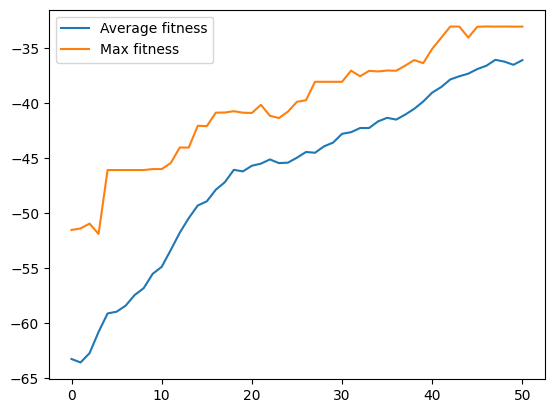

C:\Users\adams\AppData\Local\Temp\ipykernel_4296\3288827407.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(


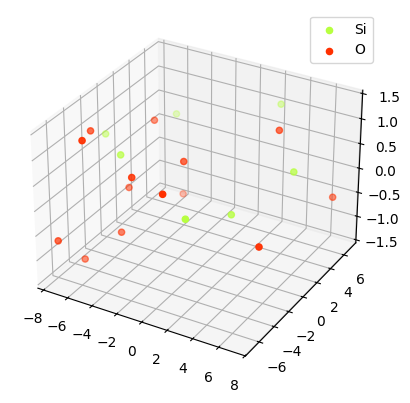

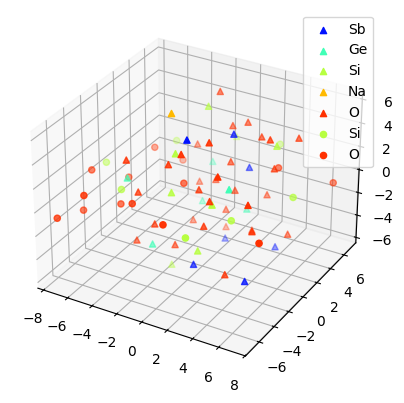

In [54]:
ga_z.plot_fitness()
best_solution_z = ga_z.get_best_solution()

plot_atoms(best_solution_z, atom_species_by_index)
plot_solution_with_walls((wall_down, wall_up), best_solution_z, atom_species_by_index)

In [56]:
export_to_xcrysden(er_cluster, best_solution_x, best_solution_y, best_solution_z, cluster_size, solution_thickness, atom_species_by_index, 'data/sol.in')